In [1]:
from __future__ import print_function, division
%matplotlib inline
import statsmodels.formula.api as smf  
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import numpy as np
import geopandas as gpd
import os
#import operator
#import requests
import sys
from scipy import stats
from fiona.crs import from_epsg

In [2]:
matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['figure.figsize'] = (12,10)

In [3]:
#nyc open data API, you need apptoken to run this cell
from sodapy import Socrata
client = Socrata("data.cityofnewyork.us", os.getenv("apptoken"))

In [4]:
results = client.get("83x8-shf7",
                     select = "job_type, zip_code, job_start_date, expiration_date, gis_latitude, gis_longitude",
                     limit=4000000)
df = pd.DataFrame.from_records(results)
df.head()

,expiration_date,gis_latitude,gis_longitude,job_start_date,job_type,zip_code
0,09/16/2003,40.644203,-73.892264,07/27/2000,A2,11236
1,11/27/2013,40.682849,-73.947219,01/26/2006,A1,11216
2,10/01/1992,40.763075,-73.969695,11/27/1991,A3,10022
3,07/01/1997,40.756925,-73.972066,03/24/1997,A2,10022
4,03/30/2017,40.747535,-73.986372,09/21/2015,A2,10001


In [5]:
df['expiration_date'] = pd.to_datetime(df['expiration_date'], errors='coerce', format='%m/%d/%Y')
df['job_start_date'] = pd.to_datetime(df['job_start_date'], errors='coerce', format='%m/%d/%Y')

In [6]:
df.shape

(3272137, 6)

In [7]:
df.dtypes

expiration_date    datetime64[ns]
gis_latitude               object
gis_longitude              object
job_start_date     datetime64[ns]
job_type                   object
zip_code                   object
dtype: object

In [8]:
df = df[df['job_start_date']>'2014-12-31']

In [9]:
df.head()

,expiration_date,gis_latitude,gis_longitude,job_start_date,job_type,zip_code
4,2017-03-30,40.747535,-73.986372,2015-09-21,A2,10001
14,2016-10-21,40.687209,-73.929918,2015-10-22,NB,11221
30,2016-06-16,40.699463,-73.897855,2015-06-17,A3,11385
38,2017-10-05,40.660736,-73.849934,2016-03-03,A1,11414
39,2016-08-12,40.788266,-73.980727,2016-05-20,A2,10024


In [10]:
df = df.dropna()

In [11]:
#calculate days of construction
df['job_days'] = df['expiration_date'] - df['job_start_date']
df['job_days'] = df['job_days'].dt.days

In [12]:
df.head()

,expiration_date,gis_latitude,gis_longitude,job_start_date,job_type,zip_code,job_days
4,2017-03-30,40.747535,-73.986372,2015-09-21,A2,10001,556
14,2016-10-21,40.687209,-73.929918,2015-10-22,NB,11221,365
30,2016-06-16,40.699463,-73.897855,2015-06-17,A3,11385,365
38,2017-10-05,40.660736,-73.849934,2016-03-03,A1,11414,581
39,2016-08-12,40.788266,-73.980727,2016-05-20,A2,10024,84


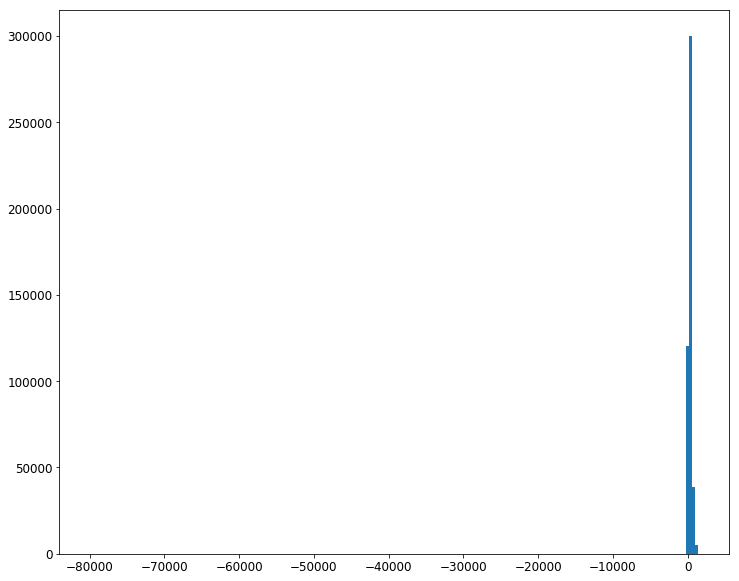

In [13]:
plt.hist(df['job_days'], bins=200)
plt.show()

In [14]:
df['job_days'].describe()

count    464892.000000
mean        307.494186
std        1247.894671
min      -79989.000000
25%         214.000000
50%         365.000000
75%         365.000000
max        1444.000000
Name: job_days, dtype: float64

In [15]:
#cases job start day later than expiration day
len(df['job_days'][df['job_days']<0])

792

In [16]:
df = df[df['job_days']>0]
df = df[df['job_days']<2000]

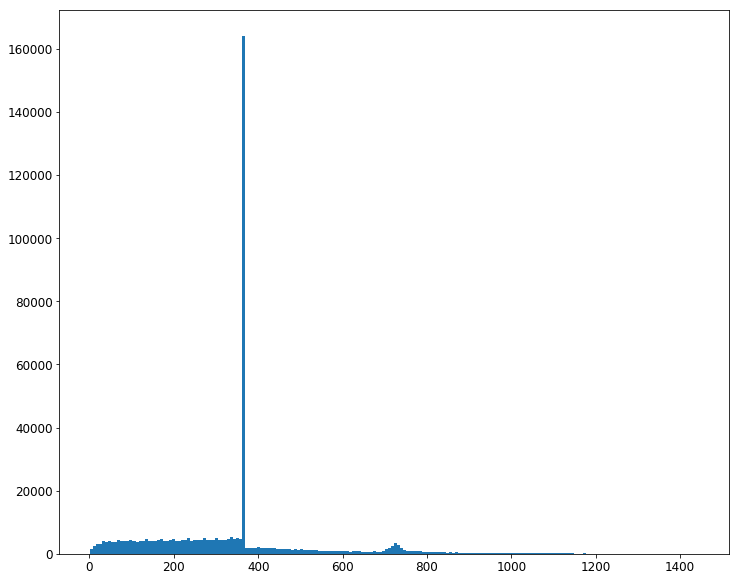

In [17]:
plt.hist(df['job_days'], bins=200)
plt.show()

In [18]:
#cases last exactly 1 year
len(df[df['job_days']==365])

161554

In [19]:
#cases by zip code
dfzip = df.groupby('zip_code').count()
dfzip.reset_index(inplace=True)
dfzip = dfzip[['zip_code', 'job_type']]
dfzip.rename(columns={'job_type': 'case_count'}, inplace=True)
dfzip.head()

,zip_code,case_count
0,00000,30
1,10000,16
2,10001,8518
3,10002,5342
4,10003,8256


In [20]:
dfzip.to_csv('DOB_counts_since2015_byzipcode.csv')

#### map

In [21]:
os.system("curl -O http://catalog.civicdashboards.com/dataset/11fd957a-8885-42ef-aa49-5c879ec93fac/resource/28377e88-8a50-428f-807c-40ba1f09159b/download/nyc-zip-code-tabulation-areas-polygons.geojson")
os.system("mv " + "nyc-zip-code-tabulation-areas-polygons.geojson " + os.getenv("PUIDATA"))
nyc = gpd.read_file(os.getenv("PUIDATA") + "/" + 'nyc-zip-code-tabulation-areas-polygons.geojson')

In [22]:
nyc['zip_code'] = nyc.postalCode.astype(str)
nyc.drop(['OBJECTID', 'postalCode', 'PO_NAME', 'STATE', 'borough', 'ST_FIPS',
          'CTY_FIPS', 'BLDGpostal', '@id', 'longitude', 'latitude'], axis=1, inplace=True)

In [23]:
mapData = pd.merge(nyc, dfzip, on='zip_code').drop_duplicates('zip_code')
mapData.head()

,geometry,zip_code,case_count
0,POLYGON ((-73.86942457284177 40.74915687096788...,11372,1771
1,POLYGON ((-73.71132911125308 40.74947450816085...,11004,731
2,POLYGON ((-73.70098278625547 40.73889569923034...,11040,168
3,POLYGON ((-73.72270447144122 40.75373371438336...,11426,714
4,"POLYGON ((-73.81088634744756 40.7271718757592,...",11365,1862


In [24]:
mapData.crs = from_epsg(4326) #from lat/long
mapData['geometry'] = nyc.to_crs(epsg=2263).geometry
mapData = gpd.GeoDataFrame(mapData)

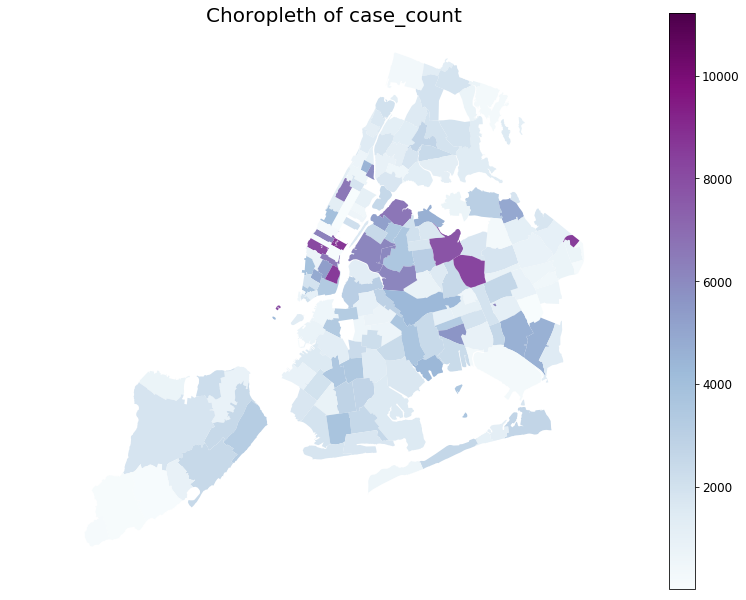

In [25]:
name = 'case_count'
ax = mapData.plot(column='{}'.format(name), cmap='BuPu', alpha=1)
vmin, vmax = min(mapData['{}'.format(name)].values), max(mapData['{}'.format(name)].values)
ax.axis('off')
ax.set_title('Choropleth of {}'.format(name), size=20)
fig = ax.get_figure()
cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
sm = plt.cm.ScalarMappable(cmap='BuPu', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
fig.colorbar(sm, cax=cax)
plt.savefig('DOB_cases', dpi=300, transparent=True)
plt.show()